## Machine Learning with Spark - Lab

## Introduction

In the previous lecture, you were shown how to manipulate data with Spark DataFrames as well as create machine learning models. In this lab, you're going to practice loading data, manipulating it, and fitting it into the Spark Framework. Afterward, you're going to make use of different visualizations to see if you can get any insights from the model. This dataset is from a Taiwanese financial company, and the task is to determine which individuals are going to default on their credit card based off of characteristics such as limit balance, past payment history, age, marriage status, and sex. Let's get started!

### Objectives

* Create machine learning pipeline with pyspark
* Evaluate a model with pyspark
* Create and interpret visualizations with pyspark

To begin with create a SparkSession and read in 'credit_card_default.csv' to a PySpark DataFrame. 

In [1]:
# import necessary libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession
# initialize Spark Session


# read in csv to a spark dataframe
spark_df = None

Check the datatypes to ensure that all columns are the datatype you expect.

[('ID', 'int'),
 ('LIMIT_BAL', 'double'),
 ('SEX', 'string'),
 ('EDUCATION', 'string'),
 ('MARRIAGE', 'string'),
 ('AGE', 'int'),
 ('PAY_0', 'int'),
 ('PAY_2', 'int'),
 ('PAY_3', 'int'),
 ('PAY_4', 'int'),
 ('PAY_5', 'int'),
 ('PAY_6', 'int'),
 ('BILL_AMT1', 'double'),
 ('BILL_AMT2', 'double'),
 ('BILL_AMT3', 'double'),
 ('BILL_AMT4', 'double'),
 ('BILL_AMT5', 'double'),
 ('BILL_AMT6', 'double'),
 ('PAY_AMT1', 'double'),
 ('PAY_AMT2', 'double'),
 ('PAY_AMT3', 'double'),
 ('PAY_AMT4', 'double'),
 ('PAY_AMT5', 'double'),
 ('PAY_AMT6', 'double'),
 ('default', 'int')]

Check to see how many null values are in the dataset. This will require using the `filter` , `isNull`, and `count` method.

In [3]:
for col in spark_df.columns:
    # your code here

column ID 0
column LIMIT_BAL 0
column SEX 0
column EDUCATION 0
column MARRIAGE 0
column AGE 0
column PAY_0 0
column PAY_2 0
column PAY_3 0
column PAY_4 0
column PAY_5 0
column PAY_6 0
column BILL_AMT1 0
column BILL_AMT2 0
column BILL_AMT3 0
column BILL_AMT4 0
column BILL_AMT5 0
column BILL_AMT6 0
column PAY_AMT1 0
column PAY_AMT2 0
column PAY_AMT3 0
column PAY_AMT4 0
column PAY_AMT5 0
column PAY_AMT6 0
column default 0


Now, determine how many categories there are in each of the categorical columns.

In [4]:
for column , data_type in spark_df.dtypes:
   # your code here

Feature  SEX  has:  [Row(SEX='Female'), Row(SEX='Male')]
Feature  EDUCATION  has:  [Row(EDUCATION='High School'), Row(EDUCATION='0'), Row(EDUCATION='5'), Row(EDUCATION='6'), Row(EDUCATION='Other'), Row(EDUCATION='Graduate'), Row(EDUCATION='College')]
Feature  MARRIAGE  has:  [Row(MARRIAGE='0'), Row(MARRIAGE='Other'), Row(MARRIAGE='Married'), Row(MARRIAGE='Single')]


Interesting... it looks like we have some extraneous values in each of our categories. Let's look at some visualizations of each of these to determine just how many of them there are. Create bar plots of the variables EDUCATION and MARRIAGE to see how many of the undefined values there are. After doing so, come up with a strategy for accounting for the extra value.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt



## plotting the categories for education


<Figure size 640x480 with 1 Axes>

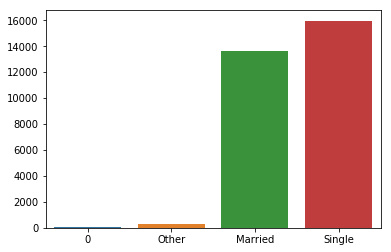

In [6]:
## plotting the categories for marriage


It looks like there are barely any of the categories of 0 and 5 categories. We can go ahead and throw them into the "Other" category since it's already operating as a catchall here. Similarly, the category "0" looks small, so let's throw it in with the "Other" values. You can do this by using a function called `when` from pyspark in conjunction with `withColumn` and `otherwise` 

In [7]:
from pyspark.sql.functions import when

## changing the values in the education column

## changing the values in the marriage column

spark_df_done = None

In [8]:
spark_df_done.head()

Row(ID=2, LIMIT_BAL=120000.0, SEX='Female', EDUCATION='College', MARRIAGE='Single', AGE=26, PAY_0=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682.0, BILL_AMT2=1725.0, BILL_AMT3=2682.0, BILL_AMT4=3272.0, BILL_AMT5=3455.0, BILL_AMT6=3261.0, PAY_AMT1=0.0, PAY_AMT2=1000.0, PAY_AMT3=1000.0, PAY_AMT4=1000.0, PAY_AMT5=0.0, PAY_AMT6=2000.0, default=1)

Now let's take a look at all the values contained in the categorical columns of the DataFrame.

In [9]:
for column , data_type in spark_df_done.dtypes:
    # your code here

Feature  SEX  has:  [Row(SEX='Female'), Row(SEX='Male')]
Feature  EDUCATION  has:  [Row(EDUCATION='High School'), Row(EDUCATION='Other'), Row(EDUCATION='Graduate'), Row(EDUCATION='College')]
Feature  MARRIAGE  has:  [Row(MARRIAGE='Other'), Row(MARRIAGE='Married'), Row(MARRIAGE='Single')]


Much better. Now, let's do a little more investigation into our target variable before diving into the machine learning aspect of this project.

##  EDA

Let's first look at the overall distribution of class balance of the default and not default label to determine if there is a need for each one of the different things here. Create a barplot to compare the number of defaults vs. non-defaults. This will require using groupBy as well as an aggregation method.

[Text(0,0,'No Default (0)'), Text(0,0,'Default (1)')]

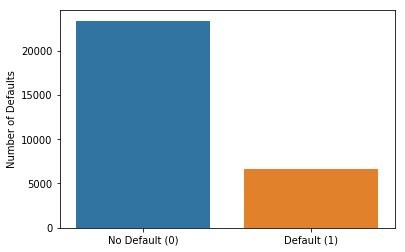

Let's also visualize the difference in default rate between males and females in this dataset.

In [14]:
# perform a groupby for default and sex


[Row(default=1, SEX='Female', count=3762),
 Row(default=0, SEX='Male', count=9015),
 Row(default=1, SEX='Male', count=2873),
 Row(default=0, SEX='Female', count=14349)]

[Text(0,0,'No Default (0)'), Text(0,0,'Default (1)')]

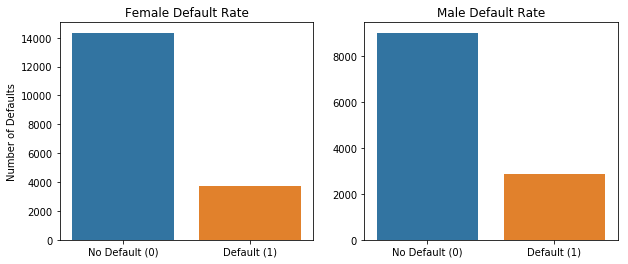

In [20]:
# make barplot for female and male default v no default rate

It looks like males have an ever so slightly higher default rate than females.

## Onto the Machine Learning!

Now, it's time to fit the data to the pyspark machine learning model pipeline.  You will need:

* 3 StringIndexers (for each categorical feature)
* A OneHotEncoderEstimator (to encode the newly indexed strings into categorical variables)
* A VectorAssembler (to combine all features into one SparseVector)

All of these initialized estimators should be stored in a list.

In [21]:
# importing the necessary modules


# creating the string indexers


# features to be included in the model 

# adding the categorical features

# putting all of the features into a single vector



[StringIndexer_47acb457ea747325b362, StringIndexer_476d9333661023960df9, StringIndexer_4477bba86fbbf3c44e9b, OneHotEncoderEstimator_41e99280e73030b62fe5, VectorAssembler_45a59eab105a2278079b]


Alright! Now let's see if that worked. Let's investigate how it transforms your dataset. Put all of the stages in a Pipeline and fit it to your data. Look at the features column. Did you obtain the number of features you expected?

In [22]:
from pyspark.ml.pipeline import Pipeline


# 17 numerical features and 6 categorical ones (the argument dropLast = True makes us have Sex, 3 Edu variables and 2 marriage)

Row(features=SparseVector(23, {0: 120000.0, 1: 26.0, 2: -1.0, 3: 2.0, 7: 2.0, 8: 2682.0, 9: 1725.0, 10: 2682.0, 11: 3272.0, 12: 3455.0, 13: 3261.0, 14: 1.0, 18: 1.0, 20: 1.0}))

## Fitting Machine Learning Models
That looks good! Now let's go ahead and fit data to different machine learning models. To evaluate these models, you should use the `BinaryClassificationEvaluator`. Below is an import of all the classes and libraries you'll need in the remainder of this lab.

In [24]:
from pyspark.ml.classification import GBTClassifier, DecisionTreeClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np

### Logistic Regression

First, we'll try with a simple Logistic Regression Model:

* instantiate a logistic regression model
* add it to the stages list
* instantiate a new Pipeline estimator (not fit) with all of the stages
* instantiate an `BinaryClassificationEvaluator`
* create parameters to gridsearch through using `ParamGridBuilder`
* Instantiate and fit a `CrossValidator` 

In [25]:
# your code here


Determine how well your model performed by looking at the evaluator metrics. If you tried multiple parameters, which performed best?

In [26]:
# print out the AUC of your best model as well as the parameters of your best model


0.7183252301096683 AUC
best parameters :  {Param(parent='LogisticRegression_4e12b7861559618c2aa6', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_4e12b7861559618c2aa6', name='standardization', doc='whether to standardize the training features before fitting the model.'): True}


#### Now try this again with other classifiers. Try and create a function that will allow you to easily test different models with different parameters. This function is optional, but it should allow for your code to be far more D.R.Y. The function should return the fitted cross-validated model as well as print out the performance metrics of the best performing model and the best parameters.

In [1]:
# create function to cross validate models with different parameters



Train a Random Forest classifier and determine the best performing model with the best parameters. This might take a while! Be smart about how you use parallelization here.

In [28]:
# code to train Random Forest Classifier


best performing model:  0.7826543113276045 AUC
best parameters:  {Param(parent='RandomForestClassifier_4ddb8a67eee4da94132a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='RandomForestClassifier_4ddb8a67eee4da94132a', name='numTrees', doc='Number of trees to train (>= 1).'): 200}


Now train a Gradient Boosting Classifier. **This might take a very long time depending on the number of parameters you are training**

In [29]:
# code to train Gradient Boosting Classifier



best performing model:  0.7798494380533647 AUC
best parameters:  {Param(parent='GBTClassifier_42569733d04d7a375612', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTClassifier_42569733d04d7a375612', name='maxIter', doc='max number of iterations (>= 0).'): 50}


It looks like the optimal performing model is the Random Forest Classifier Model because it has the highest AUC!

## Level Up

* Create ROC curves for each of these models
* Try the Multi-Layer Perceptron classifier algorithm. You will soon learn about what this means in the neural network section!

## Summary

If you've made it thus far, congratulations! Spark is an in-demand skill, but it is not particularly easy to master. In this lesson, you fit multiple different machine learning pipelines for a classification problem. If you want to boost your spark skills to the next level, connect to a distributed cluster using a service like AWS or Databricks and perform these Spark operations on the cloud.